# Project 1

In [2]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, LocallyLinearEmbedding, trustworthiness
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA
from umap import UMAP
from sklearn.metrics import adjusted_mutual_info_score, pairwise_distances
import torch, torch_directml as dml
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupShuffleSplit

In [3]:
#wARNING: THIS ONLY WORKS FOR AN AMD GRAPHICS DRIVER BECAUSE THAT WHAT I HAVE 
# just to test if dml is working
print("backend OK:", hasattr(dml, "device"))
print("using device:", dml.device())
print("torch device count (dml is logical 1):", 1)


backend OK: True
using device: privateuseone:0
torch device count (dml is logical 1): 1


## PCA for Iris data

In [4]:
# Load in the iris dataset 
iris_dat = load_iris()

X = iris_dat.data  
y = iris_dat.target

feature_names = iris_dat.feature_names
target_names = iris_dat.target_names

In [5]:
# Perform t-SNE on a dataset
def do_tsne(X, n_components=2, method="barnes_hut", perplexity=30, init="pca", random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity, 
        init=init, 
        learning_rate="auto",
        method= method, 
        random_state=random_state
    )

    X_tsne = tsne.fit_transform(X_proc)

    return X_tsne

# Preform UMAP on a dataset
def do_UMAP(X, n_neighbors=15, n_components=2 ,min_dist=0.1, metric='euclidean',
             init='spectral', random_state=None):

    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    umap = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        init=init,                      #{random}
        metric=metric,                  #{cosine}
        random_state=random_state,
        n_jobs=1
    )

    X_umap = umap.fit_transform(X_proc)

    return X_umap

# preform PCA on a dataset 
def do_PCA(X, n_components=2, whiten=False, svd_solver="auto", iterated_power="auto",
           random_state=None, return_model=False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    pca = PCA(
        n_components=n_components,
        whiten=whiten,
        svd_solver=svd_solver,          # {"auto","full","arpack","randomized"}
        iterated_power=iterated_power,  # int or "auto" (used by "randomized")
        random_state=random_state
    )
    X_pca = pca.fit_transform(X_proc)

    return (X_pca, pca) if return_model else X_pca

# preform sparce PCA on a dataset 
def do_SPCA(X, n_components=2, alpha=1.0, ridge_alpha=0.01, max_iter=1000, tol=1e-8, method="sparse", 
            batch_size=256, n_jobs=None, random_state=None, return_model = False):
    
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    # choose estimator
    if method == "minibatch":
        spca = MiniBatchSparsePCA(
            n_components=n_components,  # int >= 1
            alpha=alpha,                # float > 0 (ℓ1 sparsity strength)
            ridge_alpha=ridge_alpha,    # float >= 0 (ridge penalty on codes)
            n_jobs=n_jobs,
            batch_size=batch_size,
            max_iter=max_iter,
            tol=tol,                    # float > 0
            random_state=random_state
        )
    else:
        spca = SparsePCA(
            n_components=n_components,
            alpha=alpha,
            ridge_alpha=ridge_alpha,
            n_jobs=n_jobs,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        )
        
    # fit + transform to get low-dim codes (scores)
    Z = spca.fit_transform(X_proc)   # shape: (n_samples, n_components)

    return (Z, spca) if return_model else Z


def do_LLE(X, n_components=2, n_neighbors=10, method="standard",
            eigen_solver="auto", reg=1e-3, random_state=None, n_jobs=None):
    # ensure numpy array
    X_proc = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)

    lle = LocallyLinearEmbedding(
        n_neighbors=n_neighbors,    # int >= 2
        n_components=n_components,  # int >=1
        method=method,              # {"standard","modified","hessian","ltsa"}
        eigen_solver=eigen_solver,  # {"auto","arpack","dense"}
        reg=reg,                    # float >= 0 (ridge for reconstruction)
        random_state=random_state,
        n_jobs=n_jobs
    )

    X_lle = lle.fit_transform(X_proc)
    
    return X_lle

In [6]:
# the plotting function 
def plot_embeddings_grid(emb_dict, y, normalize=False, max_cols=3, figsize_per_plot=(5.2,4.2), s=28, alpha=0.9):
    """
    emb_dict structure:
        emb_dict[normalization_name][method_name] = {"data": 2D array, "random_state": int}
    y: array-like labels (numeric or strings)
    """

    # ---- 1) Flatten items to plot (only 2D embeddings) ----
    items = []
    for norm_name, methods in emb_dict.items():
        for method_name, payload in methods.items():
            if isinstance(payload, dict) and "data" in payload:
                X2 = np.asarray(payload["data"])
                if X2.ndim == 2 and X2.shape[1] == 2:
                    items.append((norm_name, method_name, X2, payload.get("random_state", None)))

    if not items:
        raise ValueError("No 2D embeddings found in emb_dict. Make sure each payload has a 'data' of shape (n, 2).")

    # ---- 2) Build consistent label->color map across ALL subplots ----
    y_arr = np.asarray(y).ravel()   # flatten in case y is shape (n,1)
    # preserve first-appearance order for stable colors
    labels_order = list(dict.fromkeys(y_arr.tolist()))
    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get(
        'color', ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    )
    if len(labels_order) > len(base_colors):
        repeats = int(np.ceil(len(labels_order) / len(base_colors)))
        base_colors = (base_colors * repeats)[:len(labels_order)]
    color_lookup = {lbl: base_colors[i] for i, lbl in enumerate(labels_order)}
    _ = ListedColormap([color_lookup[lbl] for lbl in labels_order])  # kept for reference

    # ---- 3) Create grid ----
    n_panels = len(items)
    n_cols = max(1, min(max_cols, n_panels))
    n_rows = int(np.ceil(n_panels / n_cols))
    fig = plt.figure(figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))

    # ---- 4) Plot each embedding ----
    for i, (norm_name, method_name, X2, seed) in enumerate(items, start=1):
        if X2.shape[0] != y_arr.shape[0]:
            raise ValueError(
                f"Label length ({y_arr.shape[0]}) does not match embedding rows ({X2.shape[0]}) "
                f"for {method_name} · {norm_name}."
            )

        ax = fig.add_subplot(n_rows, n_cols, i)
        coords = X2 if not normalize else MinMaxScaler().fit_transform(X2)

        for lbl in labels_order:
            mask = (y_arr == lbl)
            if np.any(mask):
                ax.scatter(
                    coords[mask, 0], coords[mask, 1],
                    s=s, alpha=alpha, marker='o', edgecolors='none',
                    c=[color_lookup[lbl]], label=str(lbl)
                )

        title = f"{method_name} · {norm_name}" + (f" (seed={seed})" if seed is not None else "")
        ax.set_title(title, pad=10)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.set_aspect("equal", adjustable="datalim")
        ax.grid(True, linewidth=0.3, alpha=0.4)

        # show legend only on first subplot to reduce clutter
        if i == 1:
            ax.legend(frameon=True, title="Label", loc="best")

    fig.tight_layout()
    return fig

# for part A 
def calc_LCR(X_high, X_low, k=10, metric_high='euclidean', metric_low='euclidean', return_per_point=False):
    X_high = np.asarray(X_high)
    X_low  = np.asarray(X_low)
    n = X_high.shape[0]

    # 1) k-NN in HIGH-D (compute neighbor indices; math: argmin_j ||x_i - x_j|| under metric_high)
    nn_high = NearestNeighbors(n_neighbors=k+1, metric=metric_high).fit(X_high)
    idx_high = nn_high.kneighbors(return_distance=False)[:, 1:]  # drop self (the first neighbor)

    # 2) k-NN in LOW-D (same math but in embedded coordinates)
    nn_low = NearestNeighbors(n_neighbors=k+1, metric=metric_low).fit(X_low)
    idx_low = nn_low.kneighbors(return_distance=False)[:, 1:]   # drop self

    # 3) Intersection per point; math p_i = |N_high(i) ∩ N_low(i)| / k
    #    (use set logic efficiently with boolean masks)
    per_point_pres = np.empty(n, dtype=float)
    for i in range(n):
        a = idx_high[i]
        b = idx_low[i]
        # fast intersection count: convert smaller to set
        if a.size < b.size:
            s = set(a.tolist()); inter = sum((x in s) for x in b)
        else:
            s = set(b.tolist()); inter = sum((x in s) for x in a)
        per_point_pres[i] = inter / k

    # 4) Aggregate
    preservation = float(per_point_pres.mean())
    lcr = float(1.0 - preservation)

    out = {'preservation': preservation, 'LCR': lcr}
    if return_per_point:
        out['per_point_preservation'] = per_point_pres
    return out

def calc_continuity(X_high, X_low, n_neighbors=10, metric='euclidean'):
    """
    Continuity: measures how well the embedding preserves neighborhoods
    from the *embedded space* back to the original space.
    Formula (conceptually): 1 - [average rank error of true neighbors].
    This version follows Venna & Kaski (2001).
    """
    n = X_high.shape[0]
    # Compute pairwise distances in both spaces
    D_high = pairwise_distances(X_high, metric=metric)
    D_low  = pairwise_distances(X_low,  metric=metric)
    # Get the indices of the nearest neighbors (exclude self)
    high_ranks = np.argsort(D_high, axis=1)[:, 1:n_neighbors+1]
    low_ranks  = np.argsort(D_low,  axis=1)[:, 1:n_neighbors+1]

    # Compute continuity = how many low-D neighbors are also true high-D neighbors
    ranks = np.zeros(n)
    for i in range(n):
        # neighbors in low-D that are NOT in top-k of high-D
        missing = np.setdiff1d(low_ranks[i], high_ranks[i], assume_unique=True)
        # rank positions of missing neighbors in high-D distance order
        rank_positions = np.array([np.where(np.argsort(D_high[i]) == m)[0][0] for m in missing])
        # accumulate penalty (rank - k)
        ranks[i] = np.sum(rank_positions - n_neighbors)
    C = 1 - (2 / (n * n_neighbors * (2*n - 3*n_neighbors - 1))) * np.sum(ranks)
    return float(C)

### Do PCA, and sparse PCA, t-SNE, UMAP, locally linear embedding (LLE) visualizations for Iris data under different normalization methods

In [7]:
# first lets choose some normalization methods
scalers = {
    "StandardScaler": StandardScaler(),      # Baseline 
    "MinMaxScaler": MinMaxScaler(),          # defaults to [0,1]
    "RobustScaler": RobustScaler(),          # median/IQR scaling
    "Normalizer(L2_rowwise)": Normalizer()   # row-wise normalization (conceptually different)
}

scaled_data = {}
for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    scaled_data[f"{name}-Data"] = X_scaled

# predicting that StandardScalar and MinMax will preform the best 

In [8]:
# for reproducability use a random seed
random_seed = 67
iris_transformed = {}

# get all of the data transformations after the normalizations
for name, data in scaled_data.items():
    iris_transformed[name] = {
        "PCA": {
            "data" : do_PCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "SPCA": {
            "data" : do_SPCA(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "tSNE": {
            "data" : do_tsne(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "UMAP": {
            "data" : do_UMAP(X=data, random_state=random_seed),
            "random_state": random_seed
        },
        "LLE": {
            "data" : do_LLE(X=data, n_neighbors=12, random_state=random_seed),
            "random_state": random_seed
        }
    }

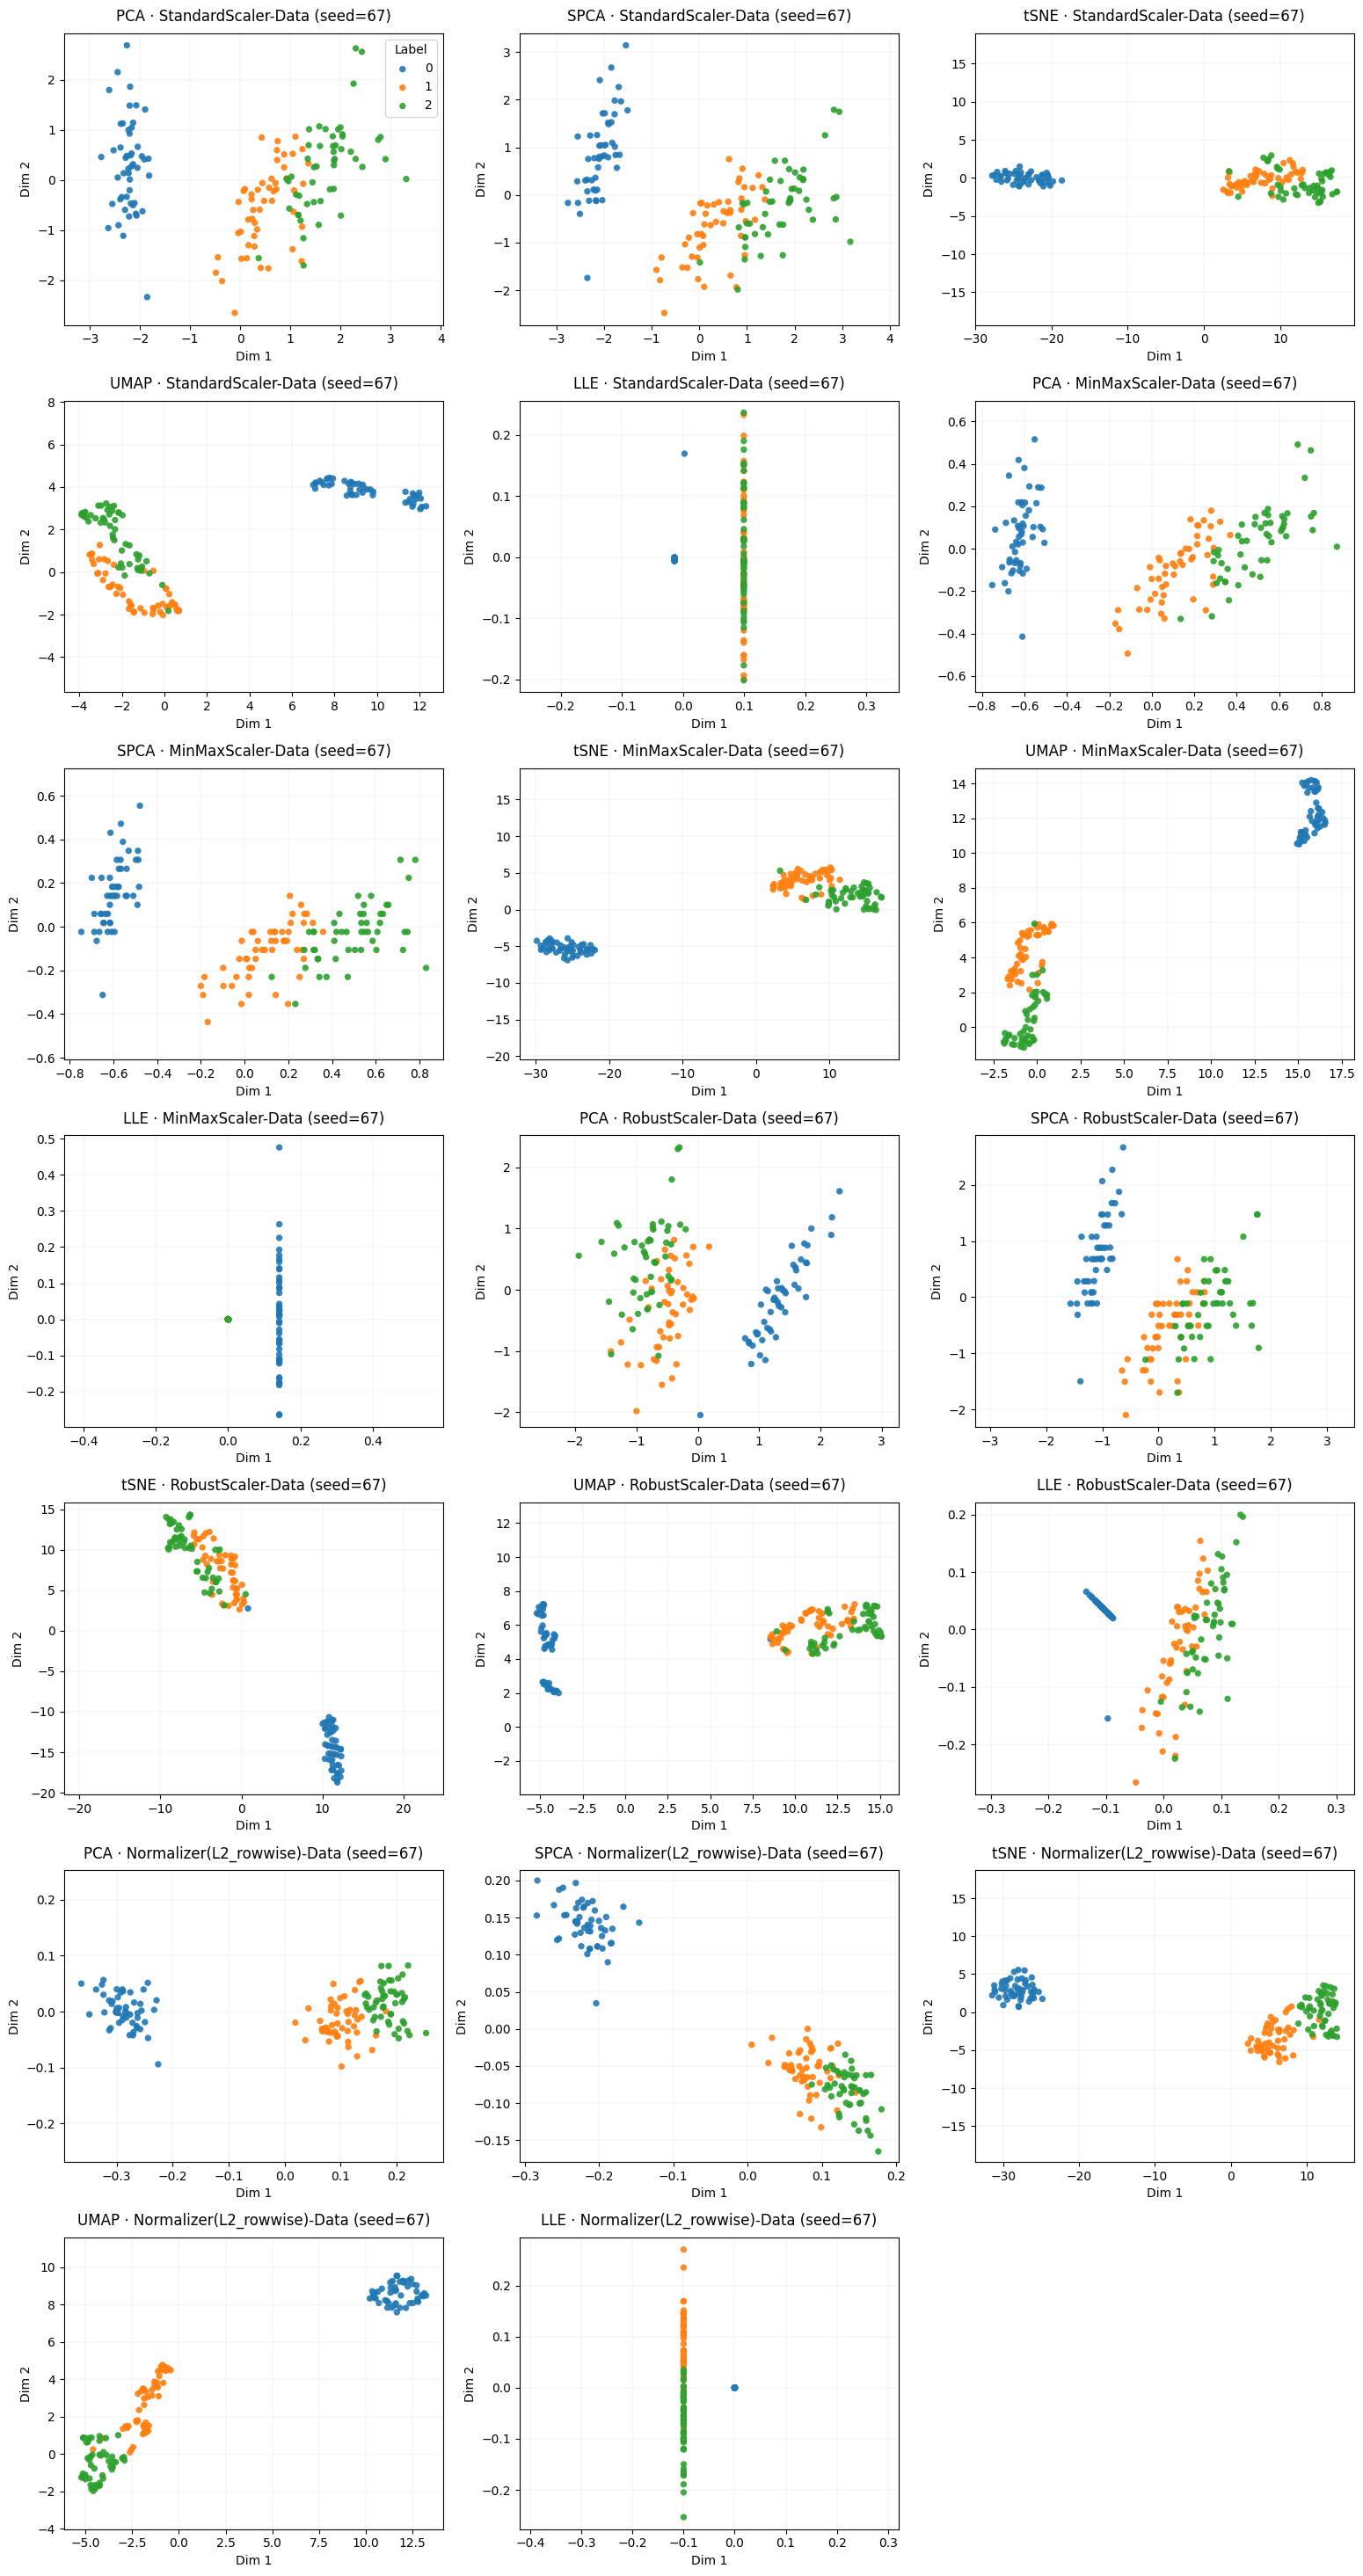

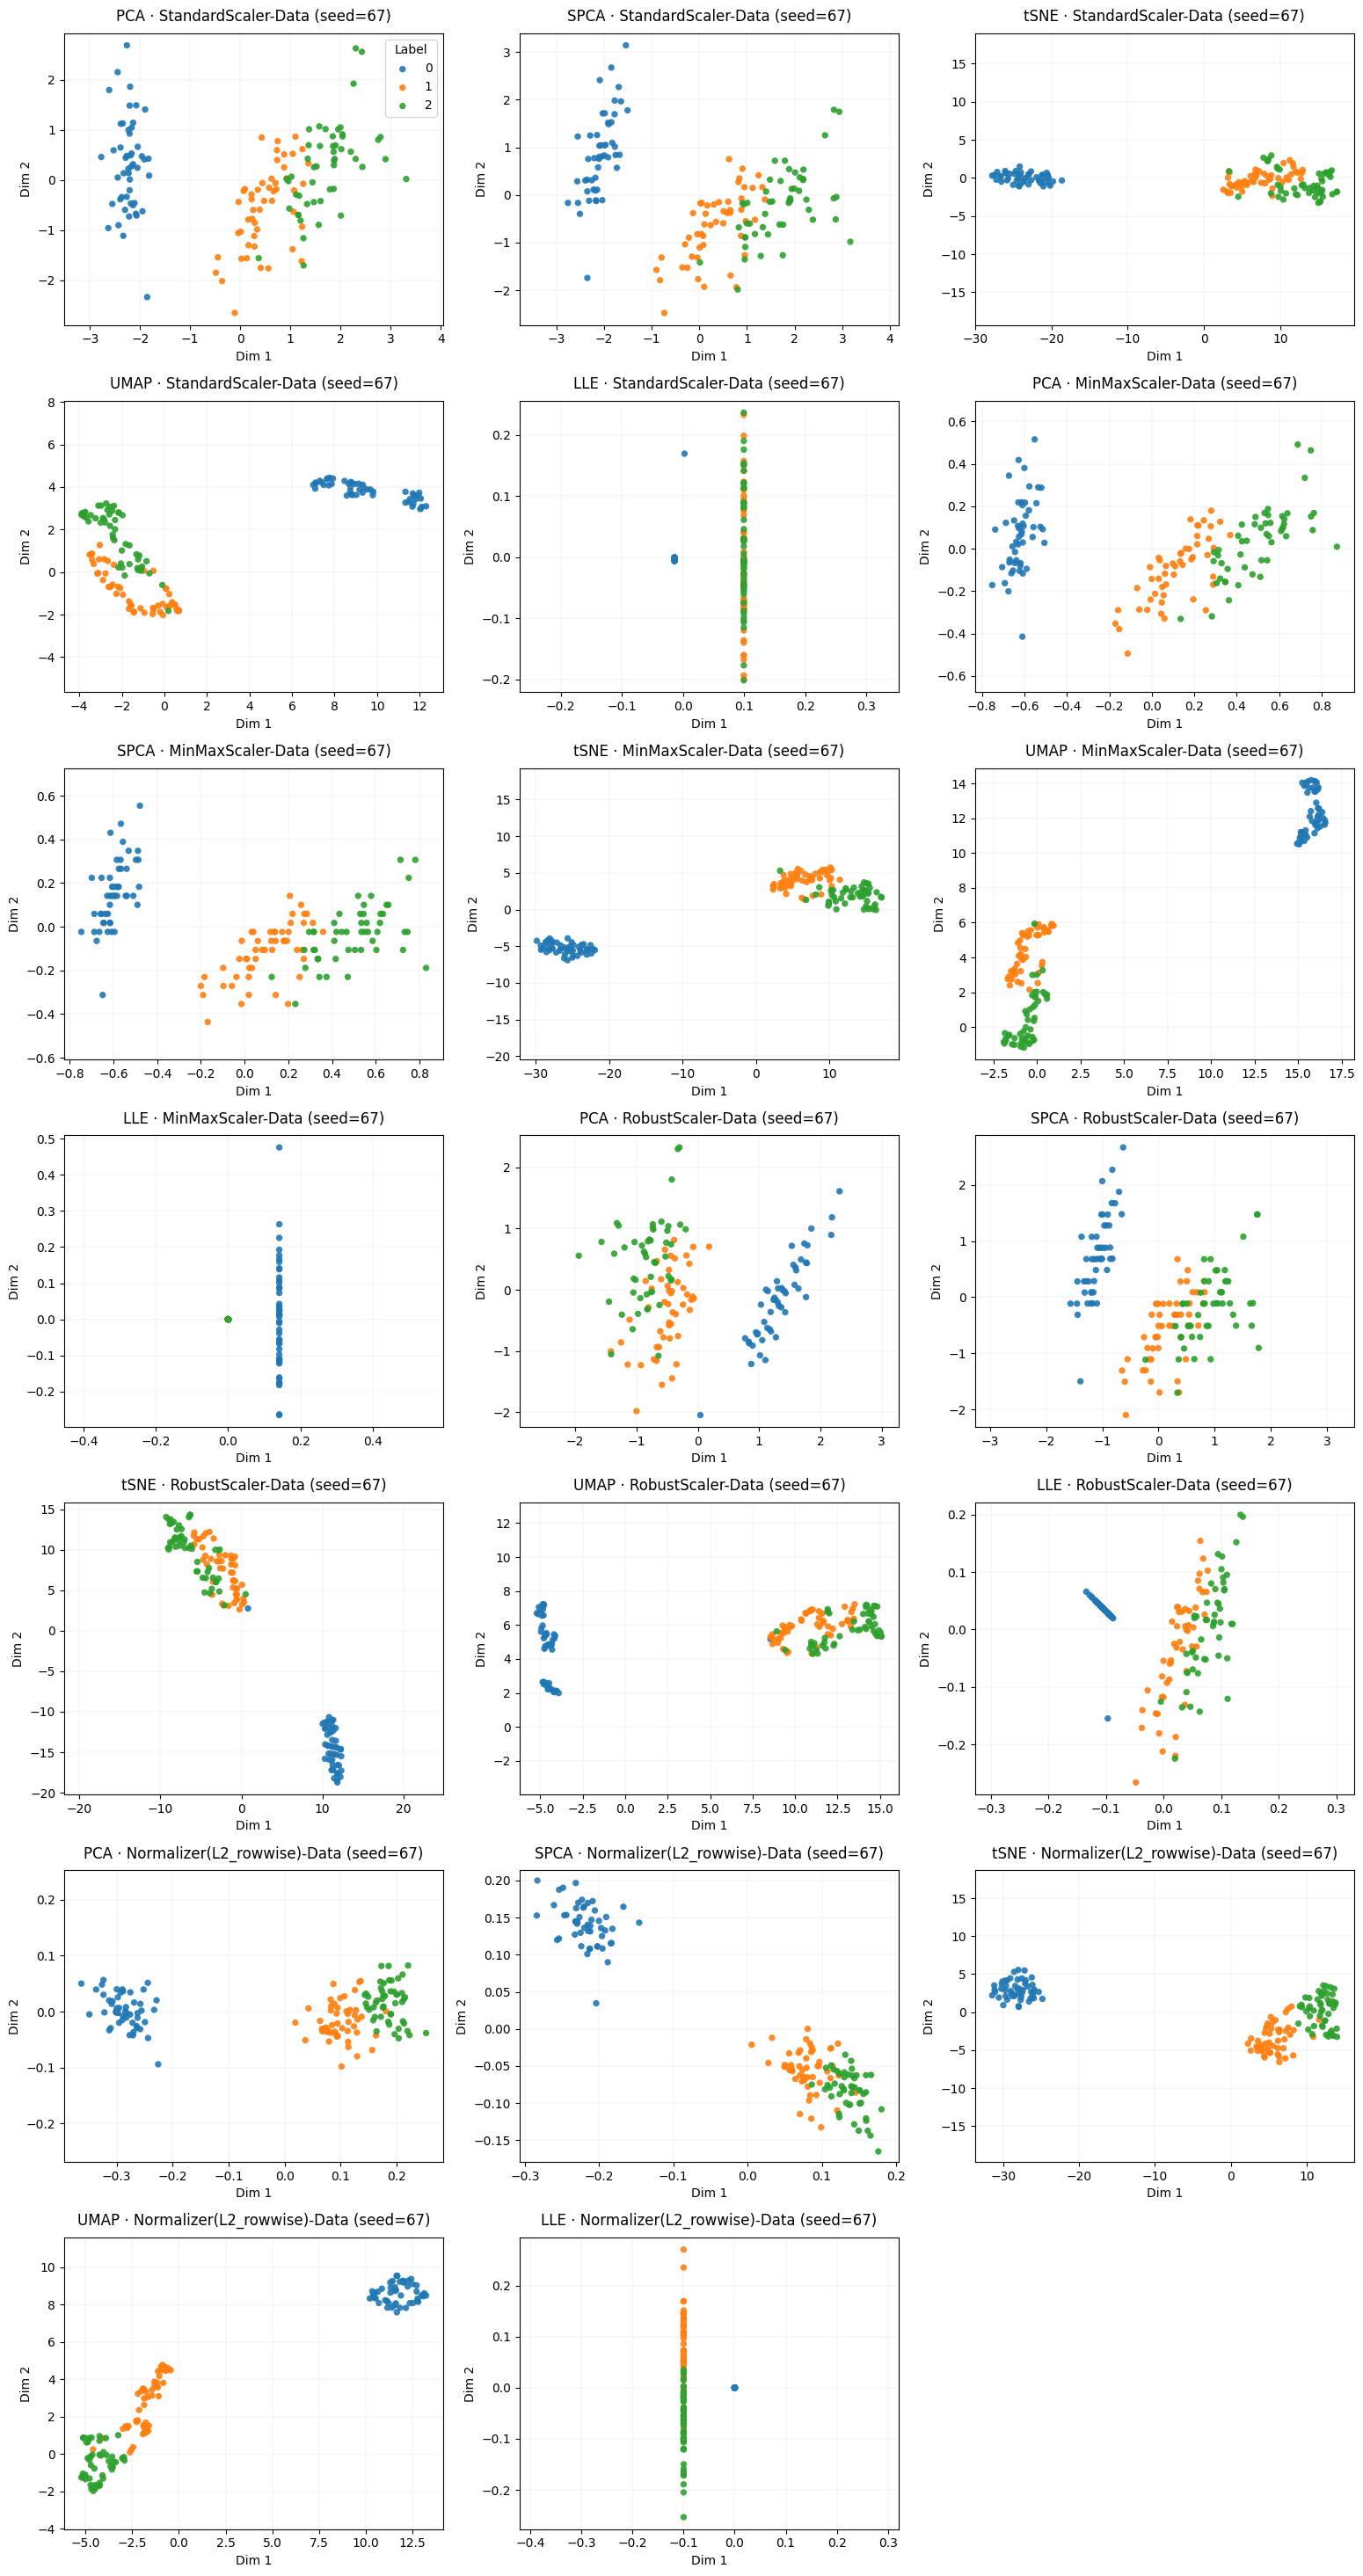

In [9]:
# LLE looks like shit but whatever  
plot_embeddings_grid(emb_dict=iris_transformed, y = y)  

In [10]:
rows = []
val_k  = 10
val_nn = 10

for norm_name, methods in iris_transformed.items():
    for method_name, payload in methods.items():
        X_low = payload["data"]

        # Compute all metrics
        res   = calc_LCR(X_high=X, X_low=X_low, k=val_k,
                         metric_high="euclidean", metric_low="euclidean")
        trust = trustworthiness(X, X_low, n_neighbors=val_nn, metric="euclidean")
        cont  = calc_continuity(X, X_low, n_neighbors=val_nn, metric="euclidean")

        # One row per (Normalization, Method)
        row = {
            "Normalization": norm_name,
            "Method": method_name,
            "Trustworthiness": float(trust),
            "Continuity": float(cont),
        }
        for k, v in res.items():
            row[k] = float(v) if isinstance(v, (int, float)) else v

        rows.append(row)

Scores_df = pd.DataFrame(rows)

# Sort by LCR descending (best first)
sort_col = "LCR" if "LCR" in Scores_df.columns else list(res.keys())[0]
Sorted_Scores_df = Scores_df.sort_values(by=sort_col, ascending=False).reset_index(drop=True)

# Optional: set multi-index for clarity
Sorted_Scores_Multi_Indexed_df = Sorted_Scores_df.set_index(["Normalization", "Method"])

In [11]:
print(Sorted_Scores_df.head(10))
print(Sorted_Scores_Multi_Indexed_df.head(10))

                 Normalization Method  Trustworthiness  Continuity  \
0            MinMaxScaler-Data    LLE         0.761001    0.796074   
1  Normalizer(L2_rowwise)-Data    LLE         0.819296    0.821517   
2  Normalizer(L2_rowwise)-Data   SPCA         0.853576    0.853566   
3          StandardScaler-Data    LLE         0.797413    0.797457   
4  Normalizer(L2_rowwise)-Data   UMAP         0.863440    0.863480   
5  Normalizer(L2_rowwise)-Data    PCA         0.870300    0.870270   
6  Normalizer(L2_rowwise)-Data   tSNE         0.865626    0.865586   
7            RobustScaler-Data    LLE         0.910627    0.910696   
8            RobustScaler-Data   UMAP         0.941140    0.941224   
9            RobustScaler-Data   SPCA         0.948362    0.948421   

   preservation       LCR  
0      0.156000  0.844000  
1      0.200000  0.800000  
2      0.283333  0.716667  
3      0.298667  0.701333  
4      0.306667  0.693333  
5      0.310667  0.689333  
6      0.322667  0.677333  
7    

Best Preforming 

MinMaxScaler with a LLE 

In [12]:
print(Sorted_Scores_Multi_Indexed_df.groupby("Normalization")[["LCR","Trustworthiness","Continuity"]].mean().sort_values("LCR", ascending=False))
print(Sorted_Scores_Multi_Indexed_df.groupby("Method")[["LCR","Trustworthiness","Continuity"]].mean().sort_values("LCR", ascending=False))

                                  LCR  Trustworthiness  Continuity
Normalization                                                     
Normalizer(L2_rowwise)-Data  0.715333         0.854448    0.854884
RobustScaler-Data            0.539333         0.941452    0.941528
MinMaxScaler-Data            0.500267         0.929173    0.936190
StandardScaler-Data          0.498533         0.931900    0.931942
             LCR  Trustworthiness  Continuity
Method                                       
LLE     0.746000         0.822084    0.831436
SPCA    0.550667         0.930125    0.930156
PCA     0.527000         0.938295    0.938320
UMAP    0.516333         0.936658    0.936704
tSNE    0.476833         0.944053    0.944063


In [13]:
print(Sorted_Scores_Multi_Indexed_df[["LCR","Trustworthiness","Continuity"]].corr().round(3))

                   LCR  Trustworthiness  Continuity
LCR              1.000           -0.956      -0.957
Trustworthiness -0.956            1.000       0.995
Continuity      -0.957            0.995       1.000


## Drug discovery

GDSC_IC50.csv is a dataset about drug sensitivity. It has 555 cells across
98 drugs, where each row represents an observation (cell) , and each col-
umn represents a drug.
- Preprocess data by removing possible missing data
- Label cells into binary types (you can determine your labeling methods)
- Use PCA to visualize data with the binary labels and find the outliers
- Use t-SNE, UMAP, LLE to visualize data data with the labels, apply DBSCAN to the embeddings of t-SNE/UMAP/LLE and find their clustering information. What can you find?

In [ ]:
drug_df = pd.read_csv("project1Fall2025_/GDSC_IC50.csv")
drug_df = drug_df.rename(columns={"Unnamed: 0": "cell_line"})
drug_df = drug_df.dropna(subset=["cell_line"])      # keep all rows with an ID
drug_df_wide = drug_df.set_index("cell_line")       # rows: cell, cols: drugs


all_na_cols = drug_df_wide.columns[drug_df_wide.isna().all()]
drug_df_wide = drug_df_wide.drop(columns=all_na_cols)

In [ ]:
med = drug_df_wide.median(axis=0, skipna=True)

# NO clue what the numbers mean therefore 
# sensitive if value >= drug median
drug_bin = (drug_df_wide.ge(med, axis=1)).astype("Int64")

# sensitive if value <= drug median
# drug_bin = (drug_df_wide.le(med, axis=1)).astype("Int64")

# fraction sensitive across available (non-NA) drugs
sens_frac = drug_bin.mean(axis=1, skipna=True)
cell_bin = (sens_frac >= 0.5).astype(int)   

# 1) wide per-drug labels (same shape as df_wide)
labels_wide = drug_bin

# 2) long per-drug labels 
labels_long = (labels_wide.reset_index().melt(id_vars="cell_line", var_name="drug", value_name="y_sensitive"))

cell_labels = pd.DataFrame({
    "cell_line": labels_wide.index,
    "sensitive_frac": sens_frac.values,
    "cell_label": cell_bin.values,         
}).set_index("cell_line")

# (optional) quick sanity checks
print("Dropped drugs (all-NA):", list(all_na_cols))
print(cell_labels.head())

In [ ]:
df = pd.read_csv("/mnt/data/GDSC_IC50.csv").rename(columns={df.columns[0]: "cell_line"})
drug_cols = [c for c in df.columns if c != "cell_line"]

long = (
    df.melt(id_vars="cell_line", value_vars=drug_cols,
            var_name="drug", value_name="logIC50")
      .dropna(subset=["logIC50"])
)

# 2) QC filters
# (a) coverage thresholds (tune as you like)
min_per_drug = 50
min_per_cell = 20

keep_drugs = long["drug"].value_counts()
keep_cells = long["cell_line"].value_counts()
long = long[long["drug"].isin(keep_drugs[keep_drugs >= min_per_drug].index)]
long = long[long["cell_line"].isin(keep_cells[keep_cells >= min_per_cell].index)]

# (b) optional winsorize (clip extremes by percentiles)
p1, p99 = long["logIC50"].quantile([0.01, 0.99])
long["logIC50"] = long["logIC50"].clip(lower=p1, upper=p99)

# 3) Split by cell_line (generalize to *new cell lines*)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(long, groups=long["cell_line"]))
train = long.iloc[tr_idx].copy()
test  = long.iloc[te_idx].copy()

# 4) Per-drug standardization (fit on TRAIN only)
mu = train.groupby("drug")["logIC50"].mean()
sd = train.groupby("drug")["logIC50"].std().replace(0, np.nan)

def zscore(df_sub):
    return (df_sub["logIC50"] - df_sub["drug"].map(mu)) / df_sub["drug"].map(sd)

train["z_logIC50"] = zscore(train)
test["z_logIC50"]  = zscore(test)

# 5) Binary label by per-drug z-threshold (sensitive=1 for low IC50)
tau = -0.5  # try {-0.25, -0.5, -1.0}
train["y_bin"] = (train["z_logIC50"] <= tau).astype(int)
test["y_bin"]  = (test["z_logIC50"]  <= tau).astype(int)

# Small sanity checks you can print/plot:
#  - Class balance overall and per-drug
bal_overall = train["y_bin"].mean()
bal_by_drug = train.groupby("drug")["y_bin"].mean().sort_values()

print("Train size:", len(train), " Test size:", len(test))
print("Overall positive rate (train):", round(bal_overall, 3))
print("Per-drug positive rate (first 10):")
print(bal_by_drug.head(10))

### PCA, t-SNE, UMAP, & PHATE visualizations for Big Patent Dataset

In [ ]:
# Read in patent data
patent_data = pd.read_csv("project1Fall2025_/PatentCleanData.csv", index_col=0)
print(patent_data.head(5))

                  1      2     3  4  5  6  7       8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  25  26       27  28   29  30  31  32  classID
Patent_Num                                                                                                                                                     
CN202010573882.6  1   4.16  0.85  1  1  1  1  430000  16   7   1   0   1   0   0   0   0   0   0   8   8   0   0   0   0  32666.0   1  209  13   6   0        1
CN202210759372.7  1   1.36  0.84  1  3  1  5  320000  10   5   1   0   0   0   0   0   0   0   0   5   5   0   0   0   0  31522.0   1  302  12   2   0        1
CN202021167614.6  2   4.16  0.56  1  1  1  7  430000   7   8   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0  33461.0   1  623  11   5   0        1
CN201911132985.2  1   4.98  0.96  5  1  5  2  110000   8   5   1   2   0   0   0   0   0   0   0   9   7   2   5   2   0  32666.0   1  209   4   2   0        1
CN201410423517.1  1  12.25  1.61  5  1  

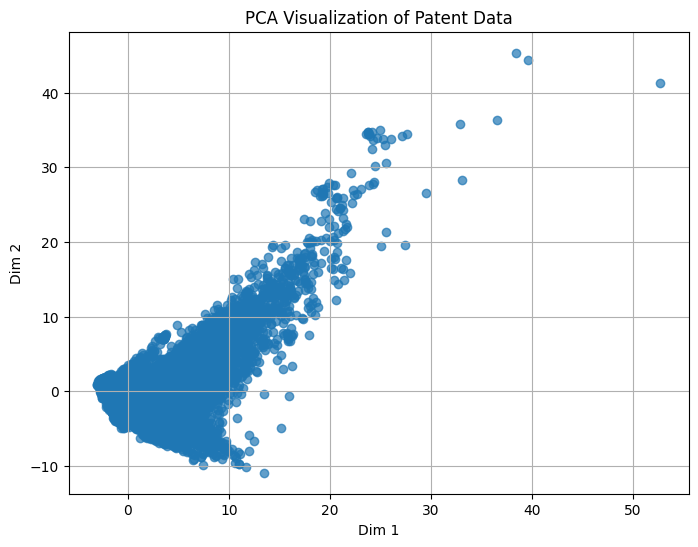

In [ ]:
PatentStandardScaler = StandardScaler()

normalized_patent_data = PatentStandardScaler.fit_transform(patent_data)
pca_patent_data = do_PCA(normalized_patent_data, n_components=2, whiten=False, svd_solver="auto", iterated_power="auto",
                         random_state=None, return_model=False)

plt.figure(figsize=(8,6))
plt.scatter(pca_patent_data[:, 0], pca_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('PCA Visualization of Patent Data')
plt.grid(True)
plt.show()

In [ ]:
# Patent Data t-SNE
tsne_patent_data = do_tsne(normalized_patent_data, n_components=2, method="barnes_hut", perplexity=30, init="random", random_state=None)

plt.figure(figsize=(8,6))
plt.scatter(tsne_patent_data[:, 0], tsne_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('t-SNE Visualization of Patent Data')
plt.grid(True)
plt.show()

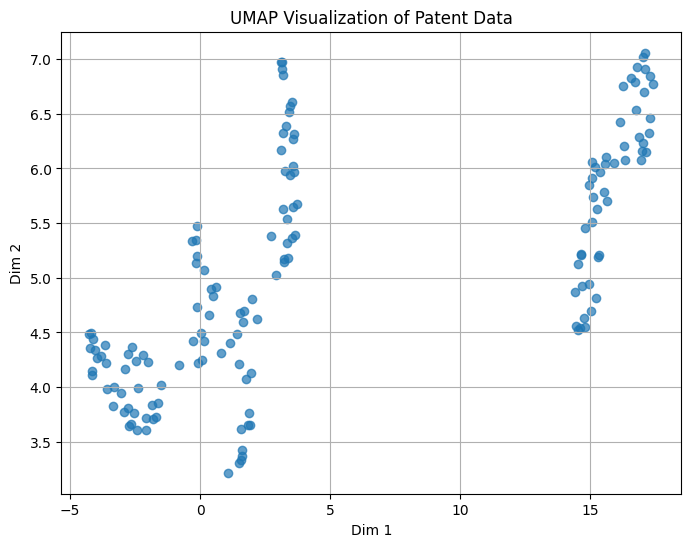

In [ ]:
# Patent Data UMAP
umap_patent_data = do_UMAP(X, n_neighbors=15, n_components=2 ,min_dist=0.1, metric='euclidean', init='spectral', random_state=None)

plt.figure(figsize=(8,6))
plt.scatter(umap_patent_data[:, 0], umap_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('UMAP Visualization of Patent Data')
plt.grid(True)
plt.show()

In [ ]:
phate_operator = phate.PHATE(n_components=2, random_state=42)
phate_patent_data = phate_operator.fit_transform(normalized_patent_data)

plt.figure(figsize=(8,6))
plt.scatter(phate_patent_data[:, 0], phate_patent_data[:, 1], alpha=0.7)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('PHATE Visualization of Patent Data')
plt.grid(True)
plt.show()

NameError: name 'phate' is not defined